In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization
from sklearn.preprocessing import MinMaxScaler


# Preparation of the data

In [305]:
# Load the CSV file
df = pd.read_csv("TimeSeriesForecasting.csv")

# Display the dataframe
df

time  column1  column2  column3  column4  column5   
0      2015-01-01 00:00:00+01:00    447.0    329.0      0.0   4844.0   4821.0  \
1      2015-01-01 01:00:00+01:00    449.0    328.0      0.0   5196.0   4755.0   
2      2015-01-01 02:00:00+01:00    448.0    323.0      0.0   4857.0   4581.0   
3      2015-01-01 03:00:00+01:00    438.0    254.0      0.0   4314.0   4131.0   
4      2015-01-01 04:00:00+01:00    428.0    187.0      0.0   4130.0   3840.0   
...                          ...      ...      ...      ...      ...      ...   
35059  2018-12-31 19:00:00+01:00    297.0      0.0      0.0   7634.0   2628.0   
35060  2018-12-31 20:00:00+01:00    296.0      0.0      0.0   7241.0   2566.0   
35061  2018-12-31 21:00:00+01:00    292.0      0.0      0.0   7025.0   2422.0   
35062  2018-12-31 22:00:00+01:00    293.0      0.0      0.0   6562.0   2293.0   
35063  2018-12-31 23:00:00+01:00    290.0      0.0      0.0   6926.0   2166.0   

       column6  column7  column8  column9  ...  column17  column18  column19   
0        162.0      0.0      0.0      0.0  ...      73.0      49.0     196.0  \
1        158.0      0.0      0.0      0.0  ...      71.0      50.0     195.0   
2        157.0      0.0      0.0      0.0  ...      73.0      50.0     196.0   
3        160.0      0.0      0.0      0.0  ...      75.0      50.0     191.0   
4        156.0      0.0      0.0      0.0  ...      74.0      42.0     189.0   
...        ...      ...      ...      ...  ...       ...       ...       ...   
35059    178.0      0.0      0.0      0.0  ...      95.0      85.0     277.0   
35060    174.0      0.0      0.0      0.0  ...      95.0      33.0     280.0   
35061    168.0      0.0      0.0      0.0  ...      94.0      31.0     286.0   
35062    163.0      0.0      0.0      0.0  ...      93.0      31.0     287.0   
35063    163.0      0.0      0.0      0.0  ...      92.0      31.0     287.0   

       column20  column21  column22  column23  column24  forecastedtargets   
0           0.0    6378.0        17       NaN      6436              26118  \
1           0.0    5890.0        16       NaN      5856              24934   
2           0.0    5461.0         8       NaN      5454              23515   
3           0.0    5238.0         2       NaN      5151              22642   
4           0.0    4935.0         9       NaN      4861              21785   
...         ...       ...       ...       ...       ...                ...   
35059       0.0    3113.0        96       NaN      3253              30619   
35060       0.0    3288.0        51       NaN      3353              29932   
35061       0.0    3503.0        36       NaN      3404              27903   
35062       0.0    3586.0        29       NaN      3273              25450   
35063       0.0    3651.0        26       NaN      3117              24424   

       targets  
0      25385.0  
1      24382.0  
2      22734.0  
3      21286.0  
4      20264.0  
...        ...  
35059  30653.0  
35060  29735.0  
35061  28071.0  
35062  25801.0  
35063  24455.0  

[35064 rows x 27 columns]

## Data cleaning

In [306]:
# Identify columns with all missing values
columns_to_drop = df.columns[df.isnull().all()]

# Drop the identified columns
df = df.drop(columns=columns_to_drop)

# Display the columns that were dropped
print(f"Colonnes supprimées : {list(columns_to_drop)}")

# Display the cleaned dataframe
df

Colonnes supprimées : ['column10', 'column23']


time  column1  column2  column3  column4  column5   
0      2015-01-01 00:00:00+01:00    447.0    329.0      0.0   4844.0   4821.0  \
1      2015-01-01 01:00:00+01:00    449.0    328.0      0.0   5196.0   4755.0   
2      2015-01-01 02:00:00+01:00    448.0    323.0      0.0   4857.0   4581.0   
3      2015-01-01 03:00:00+01:00    438.0    254.0      0.0   4314.0   4131.0   
4      2015-01-01 04:00:00+01:00    428.0    187.0      0.0   4130.0   3840.0   
...                          ...      ...      ...      ...      ...      ...   
35059  2018-12-31 19:00:00+01:00    297.0      0.0      0.0   7634.0   2628.0   
35060  2018-12-31 20:00:00+01:00    296.0      0.0      0.0   7241.0   2566.0   
35061  2018-12-31 21:00:00+01:00    292.0      0.0      0.0   7025.0   2422.0   
35062  2018-12-31 22:00:00+01:00    293.0      0.0      0.0   6562.0   2293.0   
35063  2018-12-31 23:00:00+01:00    290.0      0.0      0.0   6926.0   2166.0   

       column6  column7  column8  column9  ...  column16  column17  column18   
0        162.0      0.0      0.0      0.0  ...      43.0      73.0      49.0  \
1        158.0      0.0      0.0      0.0  ...      43.0      71.0      50.0   
2        157.0      0.0      0.0      0.0  ...      43.0      73.0      50.0   
3        160.0      0.0      0.0      0.0  ...      43.0      75.0      50.0   
4        156.0      0.0      0.0      0.0  ...      43.0      74.0      42.0   
...        ...      ...      ...      ...  ...       ...       ...       ...   
35059    178.0      0.0      0.0      0.0  ...      63.0      95.0      85.0   
35060    174.0      0.0      0.0      0.0  ...      62.0      95.0      33.0   
35061    168.0      0.0      0.0      0.0  ...      61.0      94.0      31.0   
35062    163.0      0.0      0.0      0.0  ...      61.0      93.0      31.0   
35063    163.0      0.0      0.0      0.0  ...      61.0      92.0      31.0   

       column19  column20  column21  column22  column24  forecastedtargets   
0         196.0       0.0    6378.0        17      6436              26118  \
1         195.0       0.0    5890.0        16      5856              24934   
2         196.0       0.0    5461.0         8      5454              23515   
3         191.0       0.0    5238.0         2      5151              22642   
4         189.0       0.0    4935.0         9      4861              21785   
...         ...       ...       ...       ...       ...                ...   
35059     277.0       0.0    3113.0        96      3253              30619   
35060     280.0       0.0    3288.0        51      3353              29932   
35061     286.0       0.0    3503.0        36      3404              27903   
35062     287.0       0.0    3586.0        29      3273              25450   
35063     287.0       0.0    3651.0        26      3117              24424   

       targets  
0      25385.0  
1      24382.0  
2      22734.0  
3      21286.0  
4      20264.0  
...        ...  
35059  30653.0  
35060  29735.0  
35061  28071.0  
35062  25801.0  
35063  24455.0  

[35064 rows x 25 columns]

In [307]:
# Drop columns with all zeros or NaNs
df = df.loc[:, ~((df == 0) | (df.isna())).all()] 
df

time  column1  column2  column4  column5  column6   
0      2015-01-01 00:00:00+01:00    447.0    329.0   4844.0   4821.0    162.0  \
1      2015-01-01 01:00:00+01:00    449.0    328.0   5196.0   4755.0    158.0   
2      2015-01-01 02:00:00+01:00    448.0    323.0   4857.0   4581.0    157.0   
3      2015-01-01 03:00:00+01:00    438.0    254.0   4314.0   4131.0    160.0   
4      2015-01-01 04:00:00+01:00    428.0    187.0   4130.0   3840.0    156.0   
...                          ...      ...      ...      ...      ...      ...   
35059  2018-12-31 19:00:00+01:00    297.0      0.0   7634.0   2628.0    178.0   
35060  2018-12-31 20:00:00+01:00    296.0      0.0   7241.0   2566.0    174.0   
35061  2018-12-31 21:00:00+01:00    292.0      0.0   7025.0   2422.0    168.0   
35062  2018-12-31 22:00:00+01:00    293.0      0.0   6562.0   2293.0    163.0   
35063  2018-12-31 23:00:00+01:00    290.0      0.0   6926.0   2166.0    163.0   

       column11  column12  column13  column15  column16  column17  column18   
0         863.0    1051.0    1899.0    7096.0      43.0      73.0      49.0  \
1         920.0    1009.0    1658.0    7096.0      43.0      71.0      50.0   
2        1164.0     973.0    1371.0    7099.0      43.0      73.0      50.0   
3        1503.0     949.0     779.0    7098.0      43.0      75.0      50.0   
4        1826.0     953.0     720.0    7097.0      43.0      74.0      42.0   
...         ...       ...       ...       ...       ...       ...       ...   
35059       1.0    1135.0    4836.0    6073.0      63.0      95.0      85.0   
35060       1.0    1172.0    3931.0    6074.0      62.0      95.0      33.0   
35061      50.0    1148.0    2831.0    6076.0      61.0      94.0      31.0   
35062     108.0    1128.0    2068.0    6075.0      61.0      93.0      31.0   
35063     108.0    1069.0    1686.0    6075.0      61.0      92.0      31.0   

       column19  column21  column22  column24  forecastedtargets  targets  
0         196.0    6378.0        17      6436              26118  25385.0  
1         195.0    5890.0        16      5856              24934  24382.0  
2         196.0    5461.0         8      5454              23515  22734.0  
3         191.0    5238.0         2      5151              22642  21286.0  
4         189.0    4935.0         9      4861              21785  20264.0  
...         ...       ...       ...       ...                ...      ...  
35059     277.0    3113.0        96      3253              30619  30653.0  
35060     280.0    3288.0        51      3353              29932  29735.0  
35061     286.0    3503.0        36      3404              27903  28071.0  
35062     287.0    3586.0        29      3273              25450  25801.0  
35063     287.0    3651.0        26      3117              24424  24455.0  

[35064 rows x 19 columns]

In [308]:
# Calculer le pourcentage de données manquantes par colonne
missing_percentages = df.isnull().mean() * 100

# Afficher les pourcentages de données manquantes par colonne
print(missing_percentages)

time                 0.000000
column1              0.054187
column2              0.051335
column4              0.051335
column5              0.051335
column6              0.054187
column11             0.054187
column12             0.054187
column13             0.051335
column15             0.048483
column16             0.051335
column17             0.051335
column18             0.051335
column19             0.054187
column21             0.051335
column22             0.000000
column24             0.000000
forecastedtargets    0.000000
targets              0.102669
dtype: float64


In [309]:
# Supprimer les lignes avec des données manquantes
df = df.dropna()

# Afficher le dataframe nettoyé
df

time  column1  column2  column4  column5  column6   
0      2015-01-01 00:00:00+01:00    447.0    329.0   4844.0   4821.0    162.0  \
1      2015-01-01 01:00:00+01:00    449.0    328.0   5196.0   4755.0    158.0   
2      2015-01-01 02:00:00+01:00    448.0    323.0   4857.0   4581.0    157.0   
3      2015-01-01 03:00:00+01:00    438.0    254.0   4314.0   4131.0    160.0   
4      2015-01-01 04:00:00+01:00    428.0    187.0   4130.0   3840.0    156.0   
...                          ...      ...      ...      ...      ...      ...   
35059  2018-12-31 19:00:00+01:00    297.0      0.0   7634.0   2628.0    178.0   
35060  2018-12-31 20:00:00+01:00    296.0      0.0   7241.0   2566.0    174.0   
35061  2018-12-31 21:00:00+01:00    292.0      0.0   7025.0   2422.0    168.0   
35062  2018-12-31 22:00:00+01:00    293.0      0.0   6562.0   2293.0    163.0   
35063  2018-12-31 23:00:00+01:00    290.0      0.0   6926.0   2166.0    163.0   

       column11  column12  column13  column15  column16  column17  column18   
0         863.0    1051.0    1899.0    7096.0      43.0      73.0      49.0  \
1         920.0    1009.0    1658.0    7096.0      43.0      71.0      50.0   
2        1164.0     973.0    1371.0    7099.0      43.0      73.0      50.0   
3        1503.0     949.0     779.0    7098.0      43.0      75.0      50.0   
4        1826.0     953.0     720.0    7097.0      43.0      74.0      42.0   
...         ...       ...       ...       ...       ...       ...       ...   
35059       1.0    1135.0    4836.0    6073.0      63.0      95.0      85.0   
35060       1.0    1172.0    3931.0    6074.0      62.0      95.0      33.0   
35061      50.0    1148.0    2831.0    6076.0      61.0      94.0      31.0   
35062     108.0    1128.0    2068.0    6075.0      61.0      93.0      31.0   
35063     108.0    1069.0    1686.0    6075.0      61.0      92.0      31.0   

       column19  column21  column22  column24  forecastedtargets  targets  
0         196.0    6378.0        17      6436              26118  25385.0  
1         195.0    5890.0        16      5856              24934  24382.0  
2         196.0    5461.0         8      5454              23515  22734.0  
3         191.0    5238.0         2      5151              22642  21286.0  
4         189.0    4935.0         9      4861              21785  20264.0  
...         ...       ...       ...       ...                ...      ...  
35059     277.0    3113.0        96      3253              30619  30653.0  
35060     280.0    3288.0        51      3353              29932  29735.0  
35061     286.0    3503.0        36      3404              27903  28071.0  
35062     287.0    3586.0        29      3273              25450  25801.0  
35063     287.0    3651.0        26      3117              24424  24455.0  

[35018 rows x 19 columns]

Après avoir supprimé toutes les colonnes contenant des données nulles ou manquantes, nous supprimons les lignes contenant des données nulles. Nous constatons que cela ne réduit la taille de l'ensemble de données que de $\frac{35,064-35,018}{35,064}=0.13\%$.

In [310]:
# Définir le seuil de pourcentage de valeurs égales à 0
threshold = 1.0

# Calculer le pourcentage de valeurs égales à 0 par colonne
zero_percentages = (df == 0).mean() * 100

# Identifier les colonnes à supprimer
columns_to_drop = zero_percentages[zero_percentages > threshold].index

# Supprimer les colonnes identifiées
df = df.drop(columns=columns_to_drop)

# Afficher les colonnes supprimées
print(f"Colonnes supprimées : {list(columns_to_drop)}")

# Afficher le dataframe nettoyé
df

Colonnes supprimées : ['column2', 'column11', 'column22']


time  column1  column4  column5  column6   
0      2015-01-01 00:00:00+01:00    447.0   4844.0   4821.0    162.0  \
1      2015-01-01 01:00:00+01:00    449.0   5196.0   4755.0    158.0   
2      2015-01-01 02:00:00+01:00    448.0   4857.0   4581.0    157.0   
3      2015-01-01 03:00:00+01:00    438.0   4314.0   4131.0    160.0   
4      2015-01-01 04:00:00+01:00    428.0   4130.0   3840.0    156.0   
...                          ...      ...      ...      ...      ...   
35059  2018-12-31 19:00:00+01:00    297.0   7634.0   2628.0    178.0   
35060  2018-12-31 20:00:00+01:00    296.0   7241.0   2566.0    174.0   
35061  2018-12-31 21:00:00+01:00    292.0   7025.0   2422.0    168.0   
35062  2018-12-31 22:00:00+01:00    293.0   6562.0   2293.0    163.0   
35063  2018-12-31 23:00:00+01:00    290.0   6926.0   2166.0    163.0   

       column12  column13  column15  column16  column17  column18  column19   
0        1051.0    1899.0    7096.0      43.0      73.0      49.0     196.0  \
1        1009.0    1658.0    7096.0      43.0      71.0      50.0     195.0   
2         973.0    1371.0    7099.0      43.0      73.0      50.0     196.0   
3         949.0     779.0    7098.0      43.0      75.0      50.0     191.0   
4         953.0     720.0    7097.0      43.0      74.0      42.0     189.0   
...         ...       ...       ...       ...       ...       ...       ...   
35059    1135.0    4836.0    6073.0      63.0      95.0      85.0     277.0   
35060    1172.0    3931.0    6074.0      62.0      95.0      33.0     280.0   
35061    1148.0    2831.0    6076.0      61.0      94.0      31.0     286.0   
35062    1128.0    2068.0    6075.0      61.0      93.0      31.0     287.0   
35063    1069.0    1686.0    6075.0      61.0      92.0      31.0     287.0   

       column21  column24  forecastedtargets  targets  
0        6378.0      6436              26118  25385.0  
1        5890.0      5856              24934  24382.0  
2        5461.0      5454              23515  22734.0  
3        5238.0      5151              22642  21286.0  
4        4935.0      4861              21785  20264.0  
...         ...       ...                ...      ...  
35059    3113.0      3253              30619  30653.0  
35060    3288.0      3353              29932  29735.0  
35061    3503.0      3404              27903  28071.0  
35062    3586.0      3273              25450  25801.0  
35063    3651.0      3117              24424  24455.0  

[35018 rows x 16 columns]

Je supprime maintenant les colonnes qui présentent plus d'$1\%$ de valeurs nulles, que l'on peut considérer manquantes. Cela rend le dataset plus consistant.

## Division du dataset

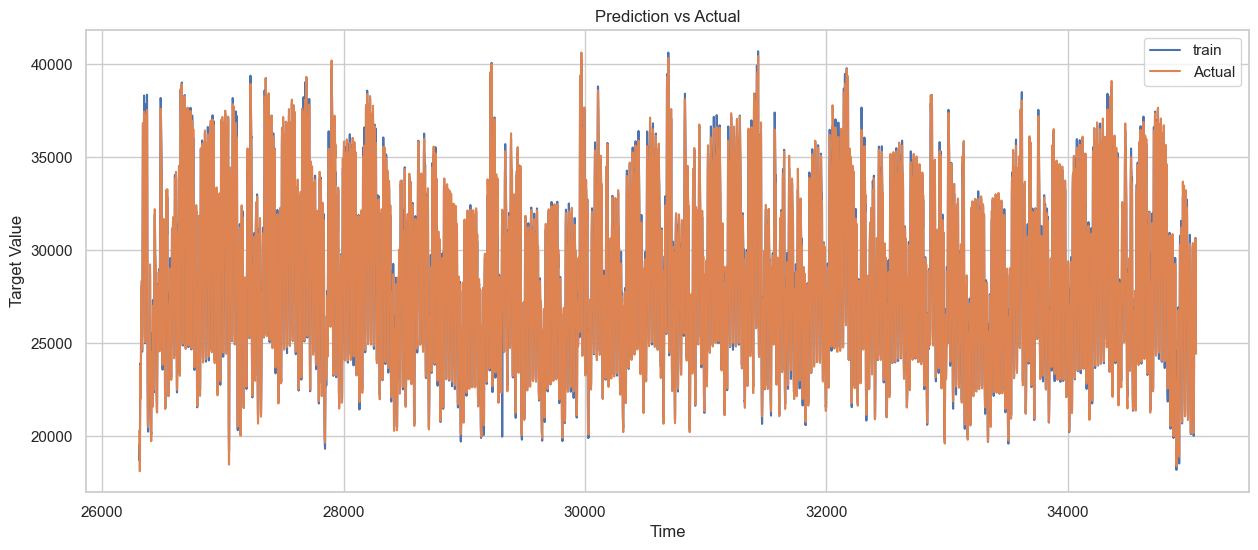

In [311]:
train_size = int(0.75 * len(df))

train_df = df[:train_size]
test_df = df[train_size:]

# affichage
train_df.shape, test_df.shape
plt.figure(figsize=(15,6))
plt.plot(test_df['targets'], label='train')
plt.plot(test_df['forecastedtargets'], label='Actual')
#plt.plot(test_df['forecastedtargets'], label='Predicted')
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [291]:
train_df

time  column1  column4  column5  column6   
0      2015-01-01 00:00:00+01:00    447.0   4844.0   4821.0    162.0  \
1      2015-01-01 01:00:00+01:00    449.0   5196.0   4755.0    158.0   
2      2015-01-01 02:00:00+01:00    448.0   4857.0   4581.0    157.0   
3      2015-01-01 03:00:00+01:00    438.0   4314.0   4131.0    160.0   
4      2015-01-01 04:00:00+01:00    428.0   4130.0   3840.0    156.0   
...                          ...      ...      ...      ...      ...   
26302  2017-12-31 22:00:00+01:00    277.0   3266.0    791.0    195.0   
26303  2017-12-31 23:00:00+01:00    278.0   3552.0    926.0    196.0   
26304  2018-01-01 00:00:00+01:00    282.0   3471.0    996.0    194.0   
26305  2018-01-01 01:00:00+01:00    275.0   3269.0    959.0    191.0   
26306  2018-01-01 02:00:00+01:00    278.0   3541.0   1014.0    191.0   

       column12  column13  column15  column16  column17  column18  column19   
0        1051.0    1899.0    7096.0      43.0      73.0      49.0     196.0  \
1        1009.0    1658.0    7096.0      43.0      71.0      50.0     195.0   
2         973.0    1371.0    7099.0      43.0      73.0      50.0     196.0   
3         949.0     779.0    7098.0      43.0      75.0      50.0     191.0   
4         953.0     720.0    7097.0      43.0      74.0      42.0     189.0   
...         ...       ...       ...       ...       ...       ...       ...   
26302    1087.0    1096.0    7095.0      53.0      80.0       9.0     240.0   
26303    1087.0    1127.0    7092.0      53.0      81.0       9.0     237.0   
26304    1076.0    1162.0    7057.0      52.0      79.0       9.0     237.0   
26305    1046.0     799.0    7057.0      51.0      77.0       9.0     238.0   
26306    1048.0     898.0    7058.0      51.0      79.0       9.0     236.0   

       column21  column24  forecastedtargets  targets  
0        6378.0      6436              26118  25385.0  
1        5890.0      5856              24934  24382.0  
2        5461.0      5454              23515  22734.0  
3        5238.0      5151              22642  21286.0  
4        4935.0      4861              21785  20264.0  
...         ...       ...                ...      ...  
26302   13787.0     14087              25114  25043.0  
26303   13560.0     13549              24084  23680.0  
26304   12348.0     12879              23324  22779.0  
26305   11156.0     11527              22688  22009.0  
26306    9437.0     10749              21521  20589.0  

[26263 rows x 16 columns]

# Analyse

## Affichage des séries temporelles

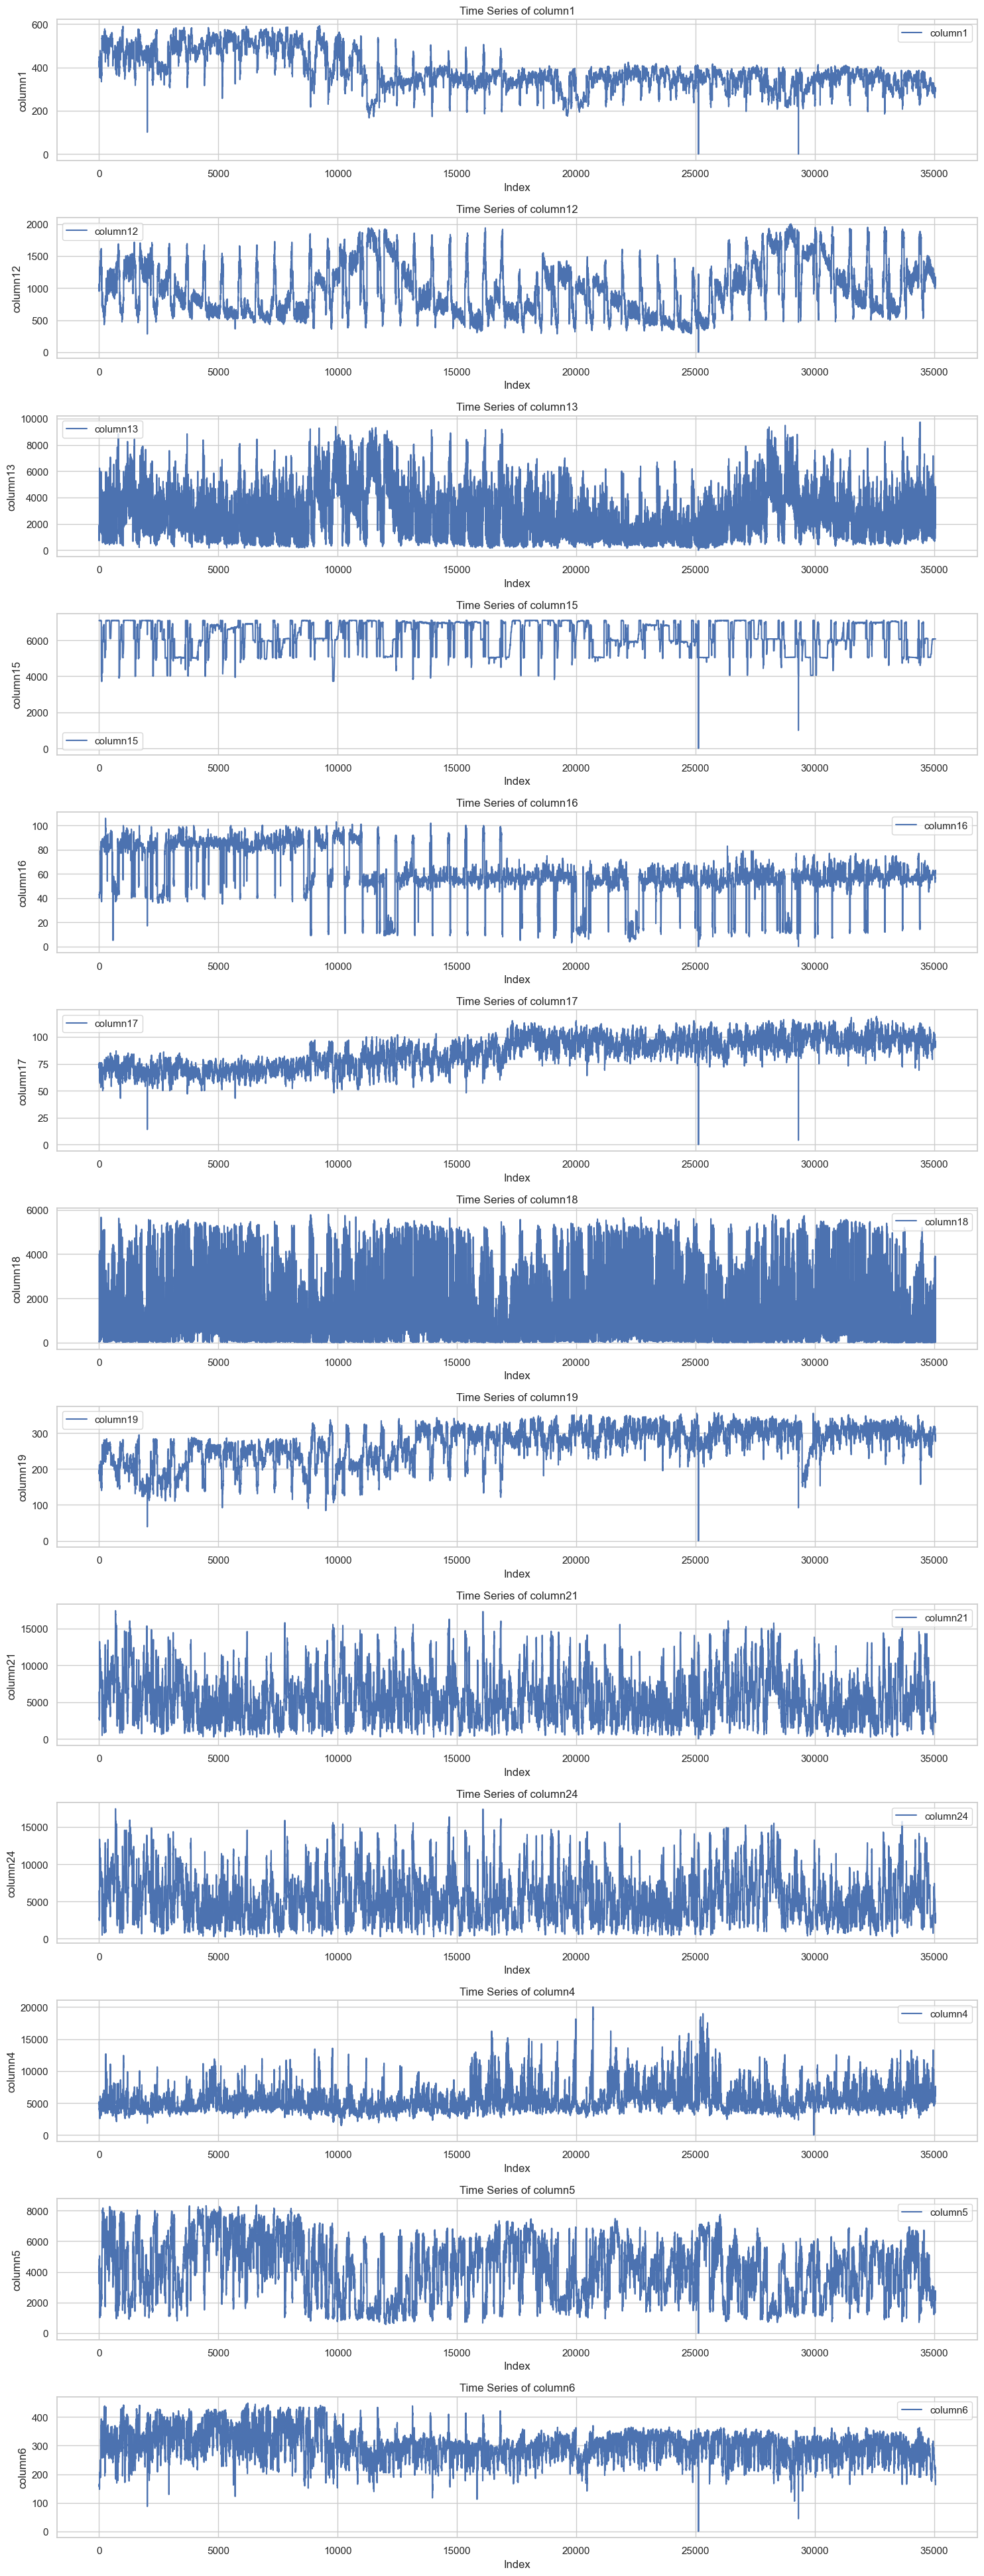

In [313]:
sns.set(style="whitegrid")

# columns à plotter (toutes les colonnes sauf 'time')
columns_to_plot = df.columns.difference(['time', 'forecastedtargets', 'targets'])

# Creation graphes
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(15, len(columns_to_plot) * 3))

# Plot
for i, col in enumerate(columns_to_plot):
    sns.lineplot(data=df, x=df.index, y=col, ax=axes[i], label=col)
    axes[i].set_title(f'Time Series of {col}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

## Analyse des séries temporelles

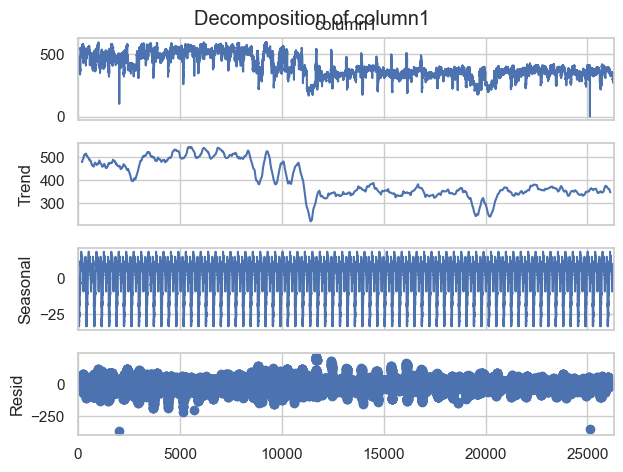

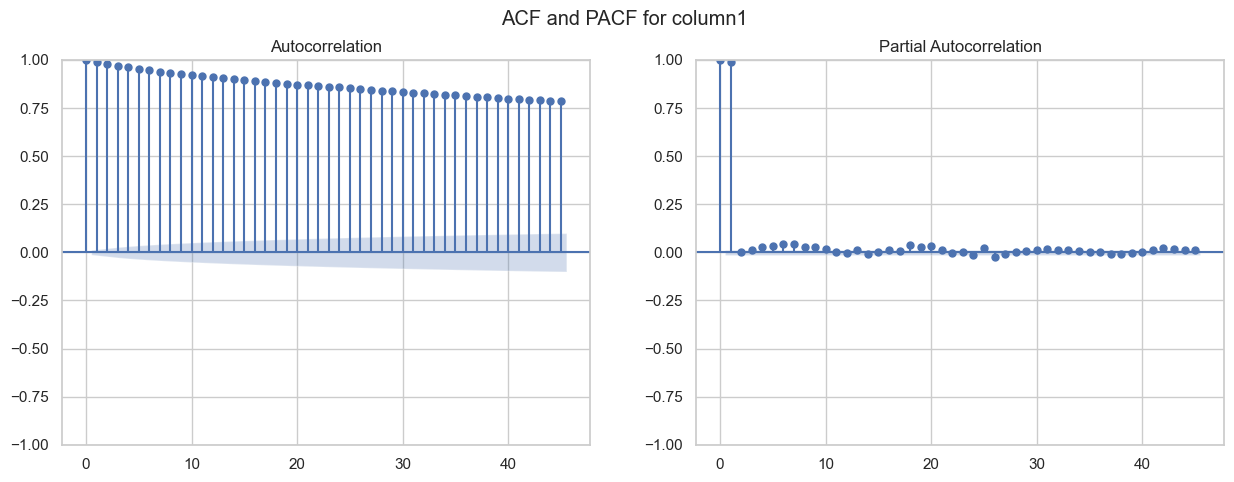

Results of Dickey-Fuller Test for column1:
Test Statistic                -6.736550e+00
p-value                        3.196739e-09
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


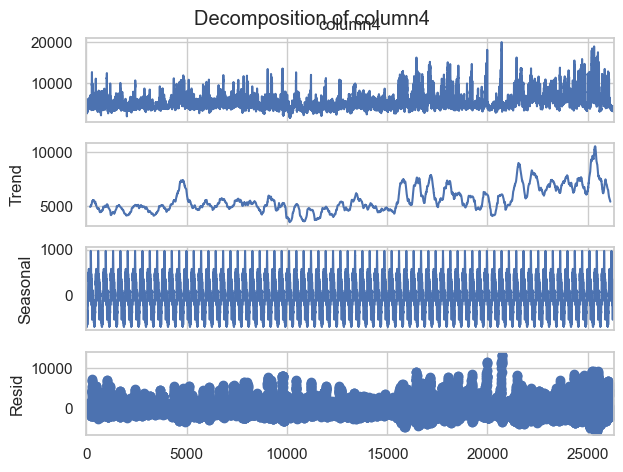

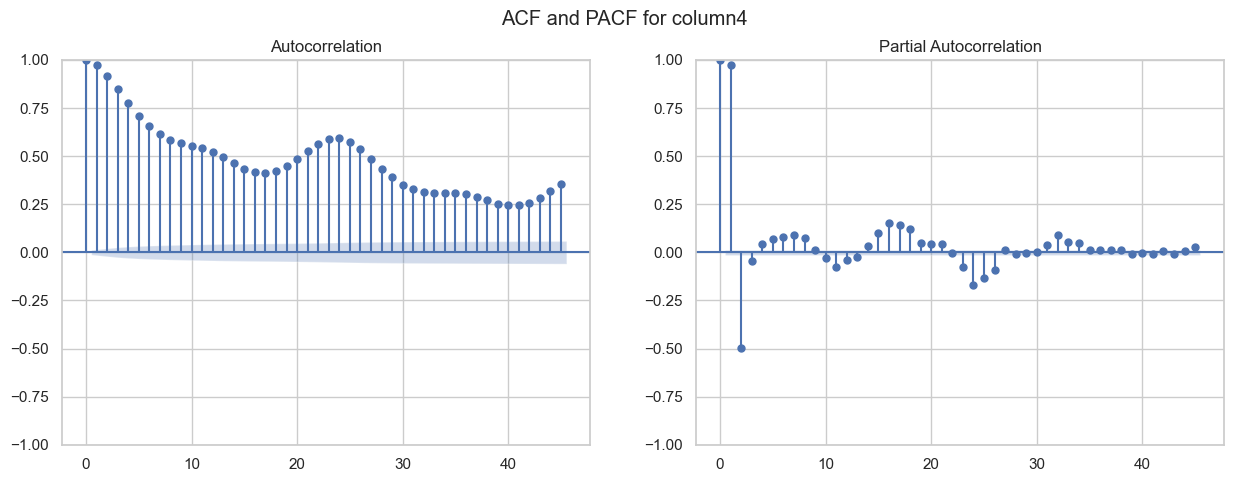

Results of Dickey-Fuller Test for column4:
Test Statistic                -1.403835e+01
p-value                        3.337875e-26
#Lags Used                     4.800000e+01
Number of Observations Used    2.621400e+04
dtype: float64


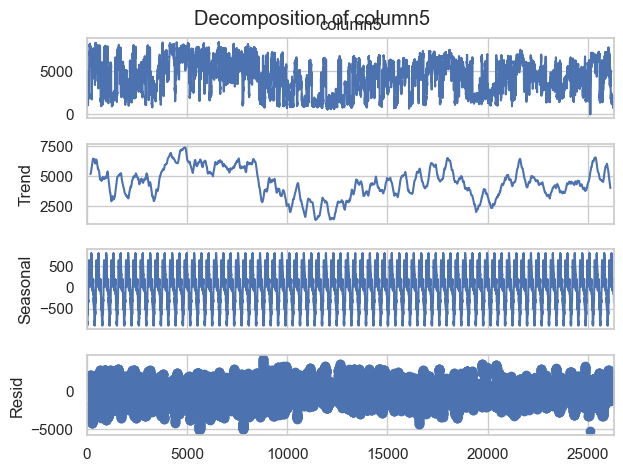

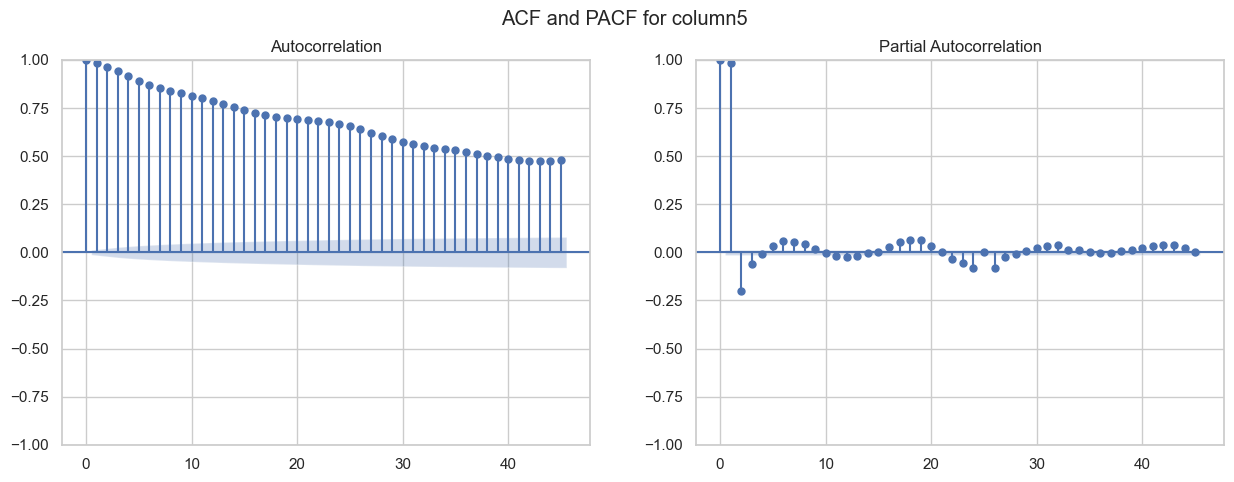

Results of Dickey-Fuller Test for column5:
Test Statistic                -1.179382e+01
p-value                        9.684963e-22
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


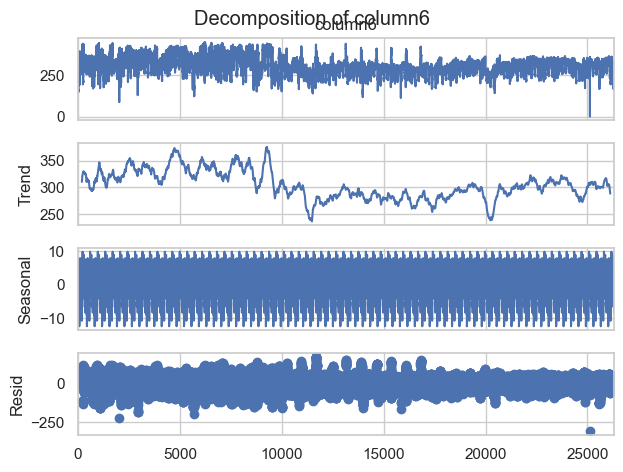

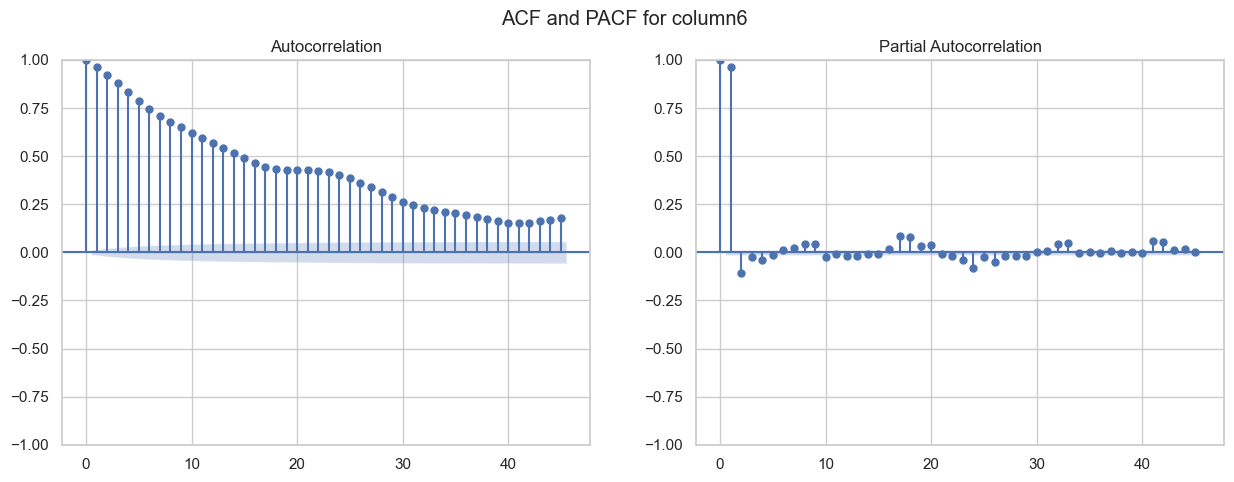

Results of Dickey-Fuller Test for column6:
Test Statistic                -1.597232e+01
p-value                        6.982132e-29
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


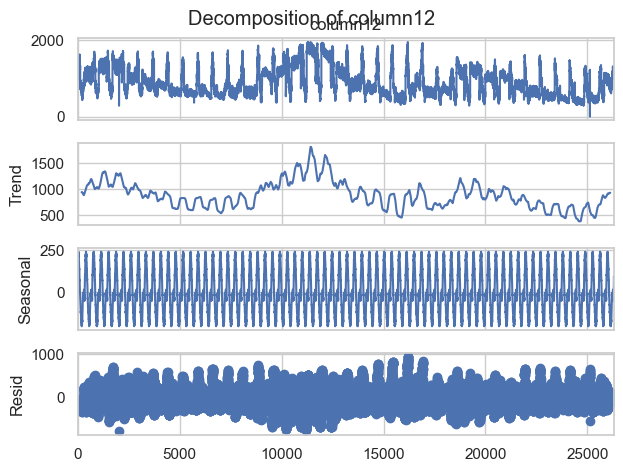

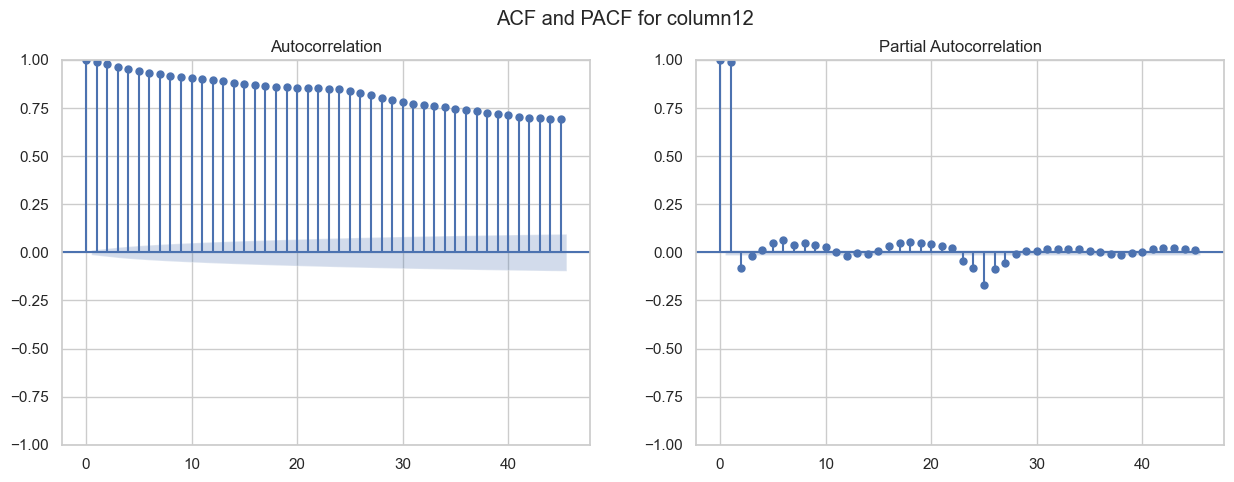

Results of Dickey-Fuller Test for column12:
Test Statistic                -1.129298e+01
p-value                        1.365312e-20
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


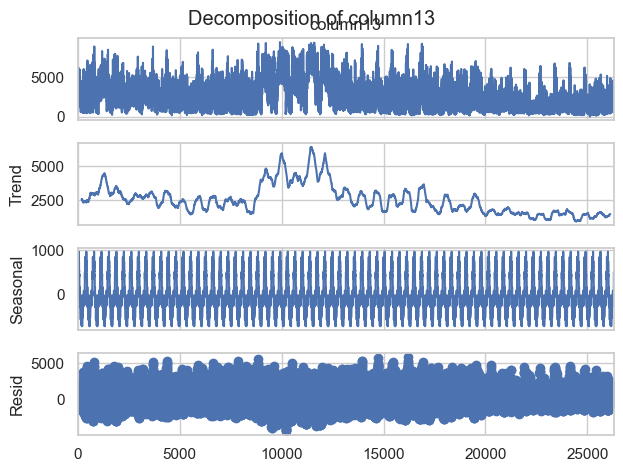

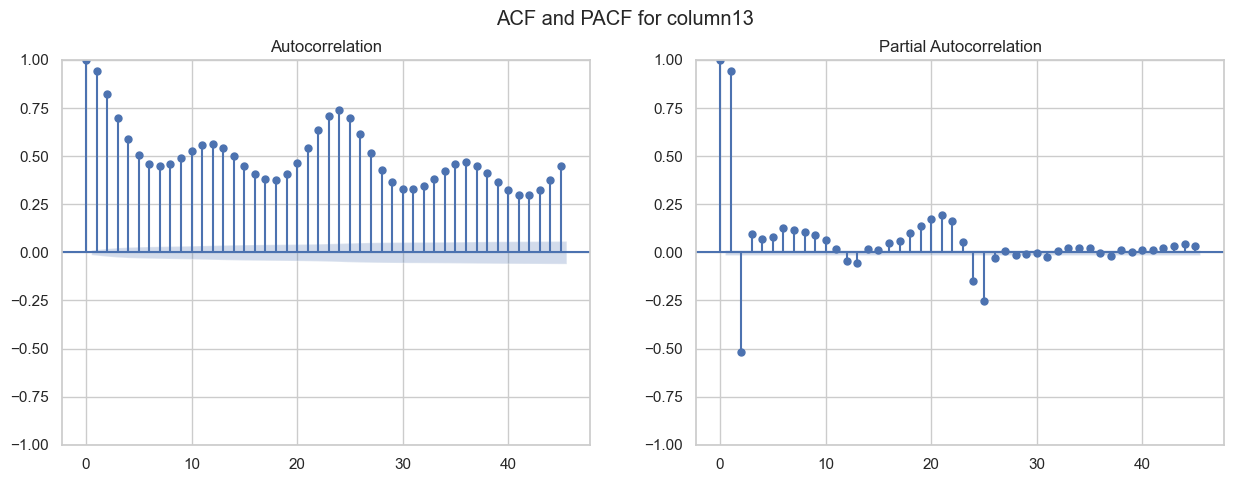

Results of Dickey-Fuller Test for column13:
Test Statistic                -9.658035e+00
p-value                        1.377234e-16
#Lags Used                     4.800000e+01
Number of Observations Used    2.621400e+04
dtype: float64


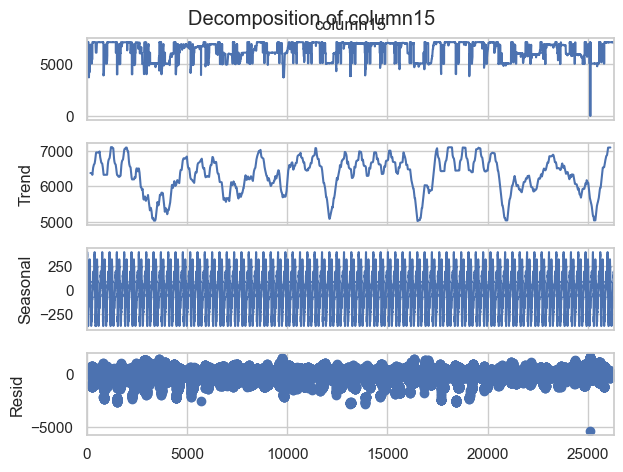

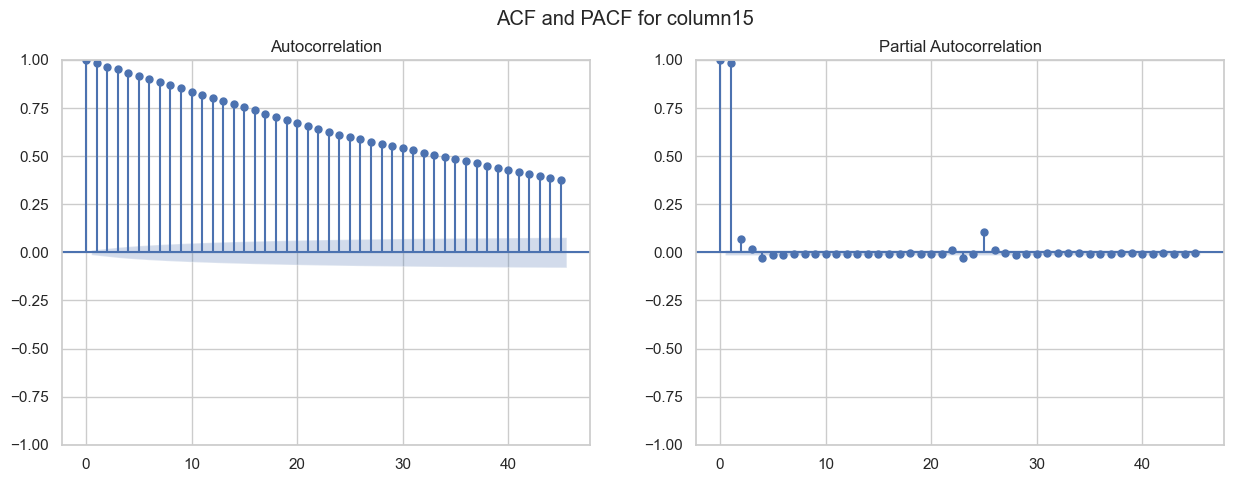

Results of Dickey-Fuller Test for column15:
Test Statistic                -1.079428e+01
p-value                        2.094805e-19
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


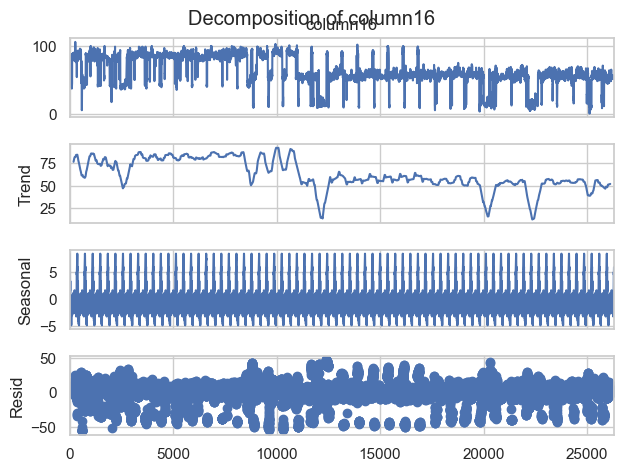

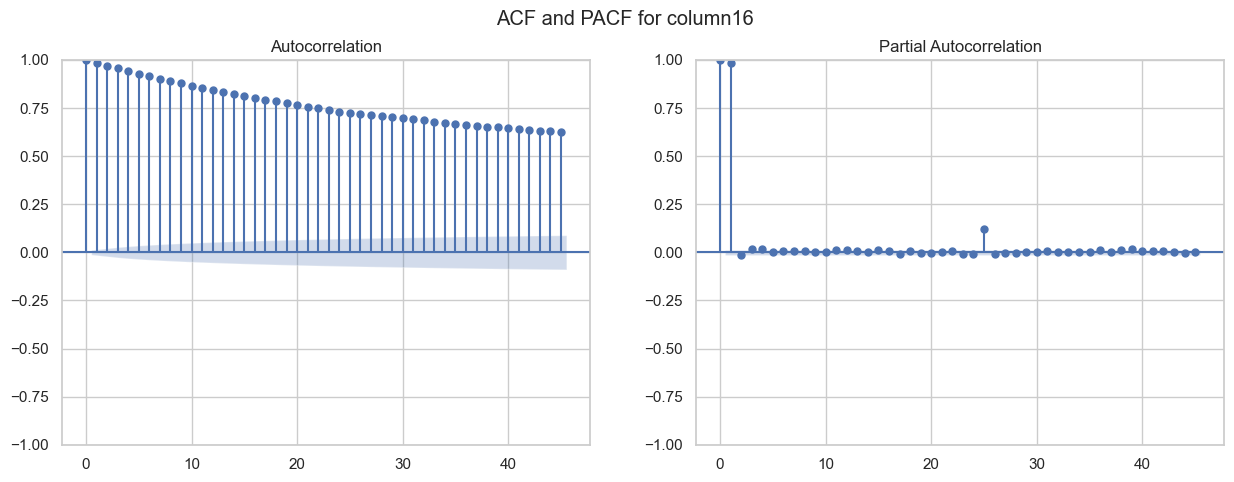

Results of Dickey-Fuller Test for column16:
Test Statistic                -8.488726e+00
p-value                        1.331281e-13
#Lags Used                     4.800000e+01
Number of Observations Used    2.621400e+04
dtype: float64


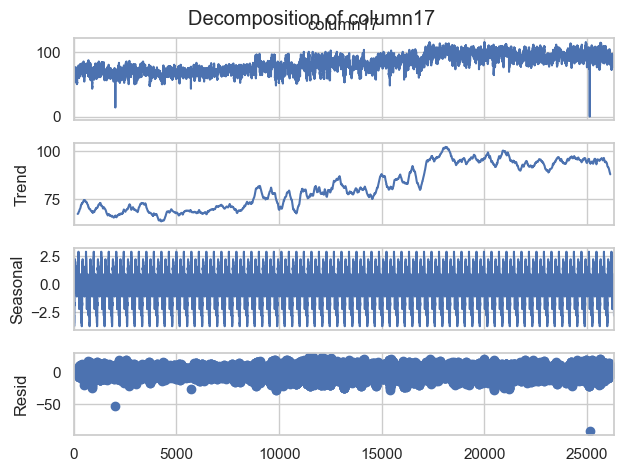

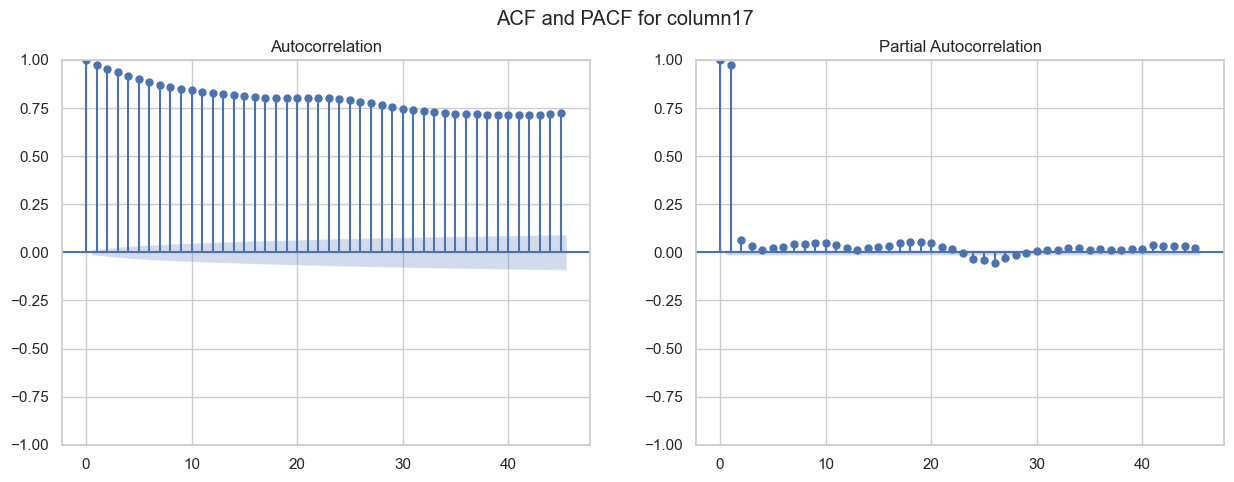

Results of Dickey-Fuller Test for column17:
Test Statistic                -7.266831e+00
p-value                        1.626733e-10
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


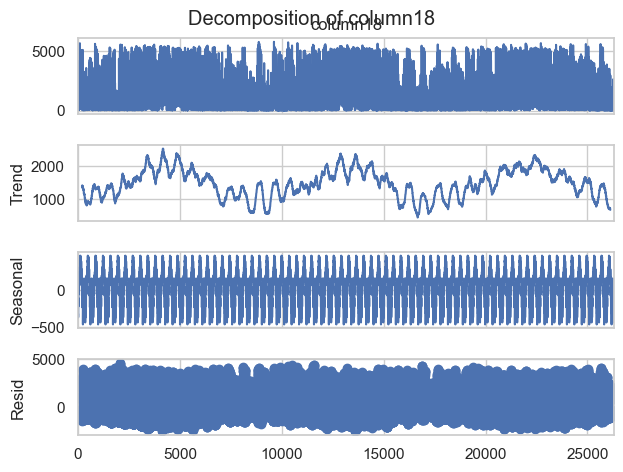

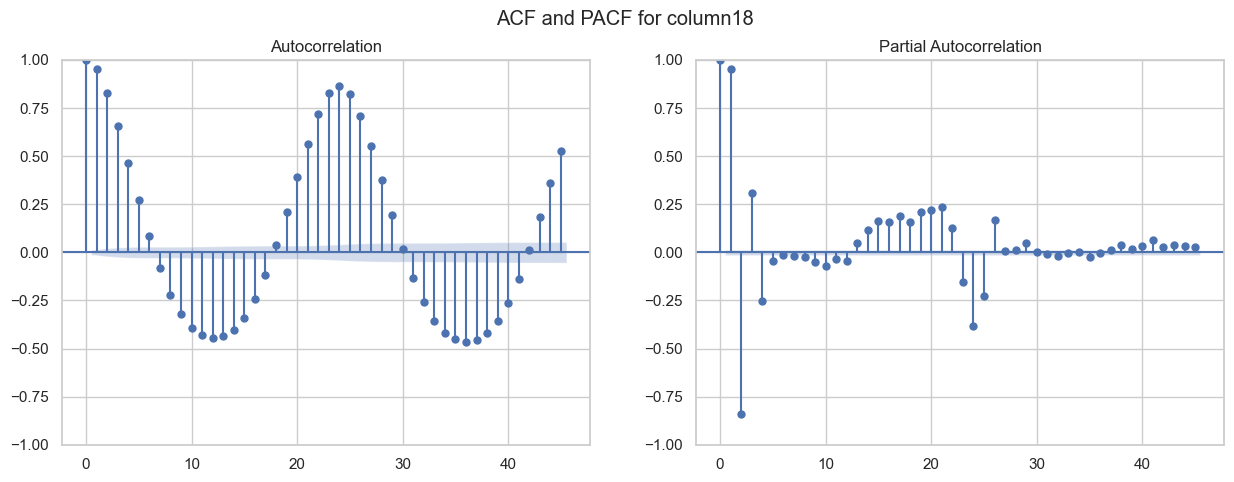

Results of Dickey-Fuller Test for column18:
Test Statistic                -1.203199e+01
p-value                        2.859949e-22
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


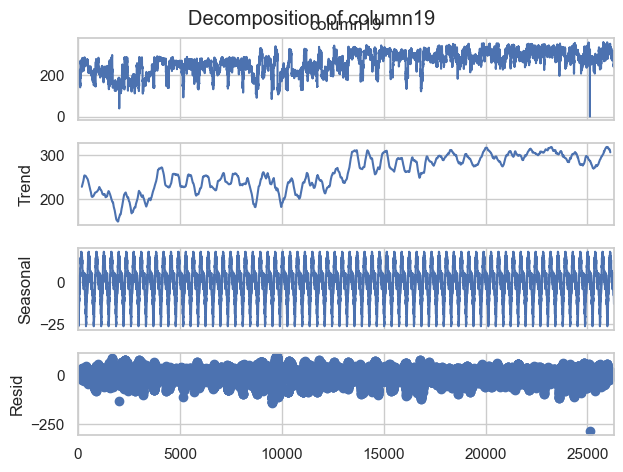

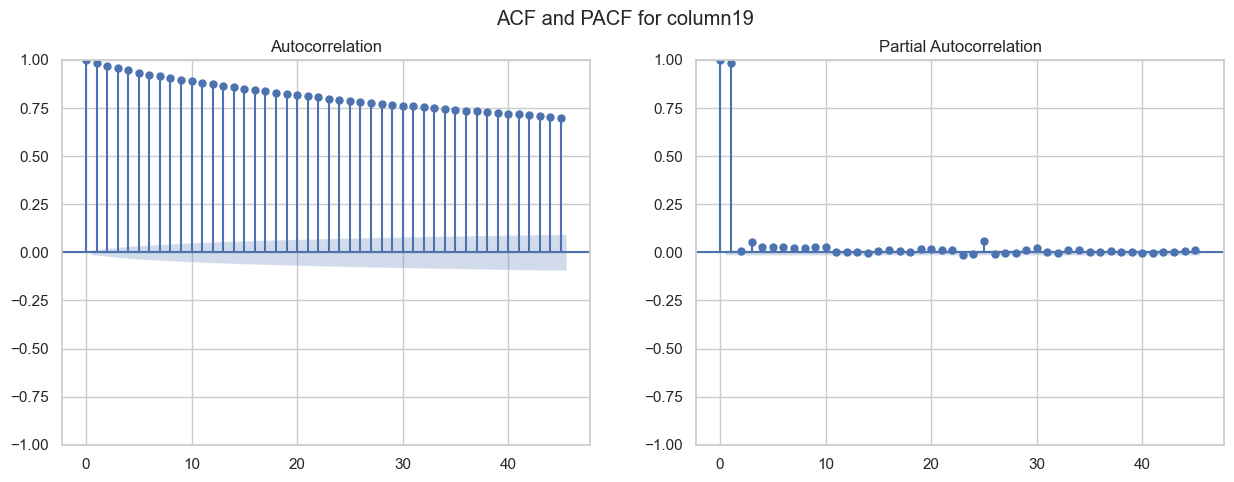

Results of Dickey-Fuller Test for column19:
Test Statistic                -8.221237e+00
p-value                        6.421265e-13
#Lags Used                     4.800000e+01
Number of Observations Used    2.621400e+04
dtype: float64


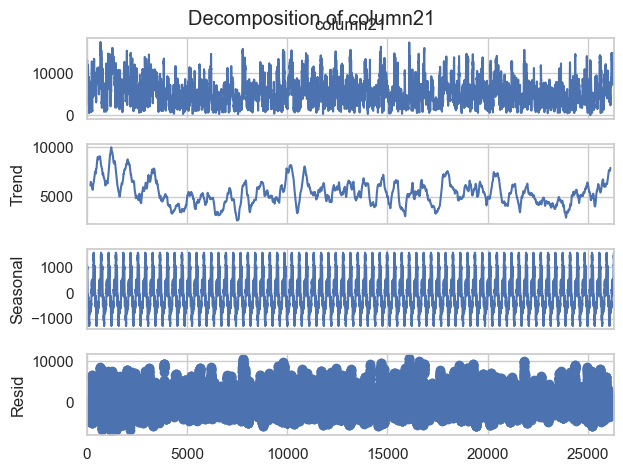

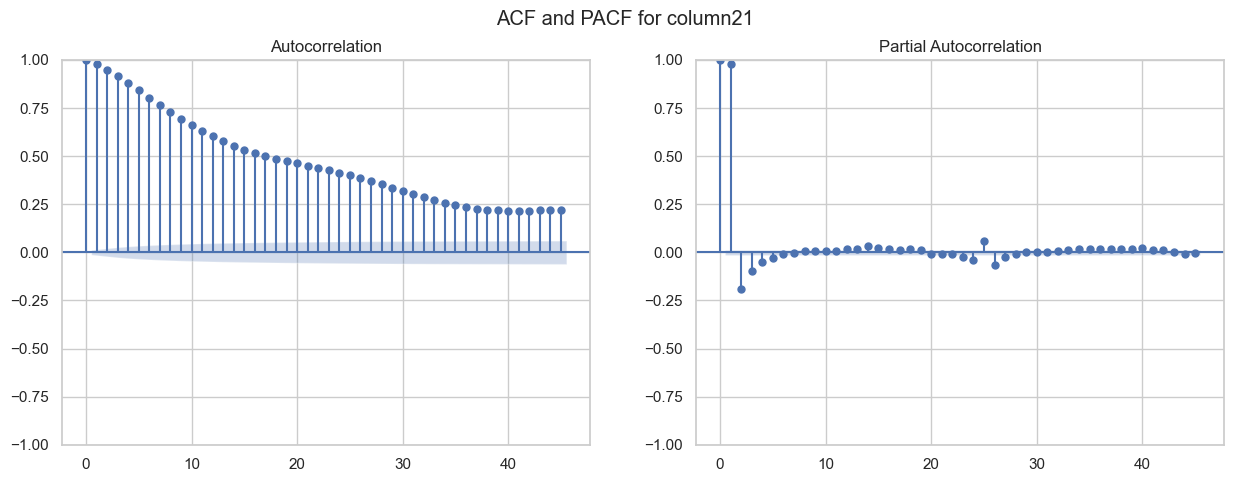

Results of Dickey-Fuller Test for column21:
Test Statistic                -1.557809e+01
p-value                        1.948288e-28
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


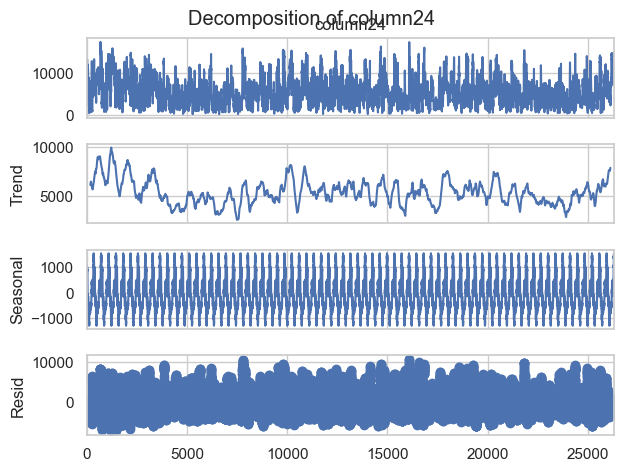

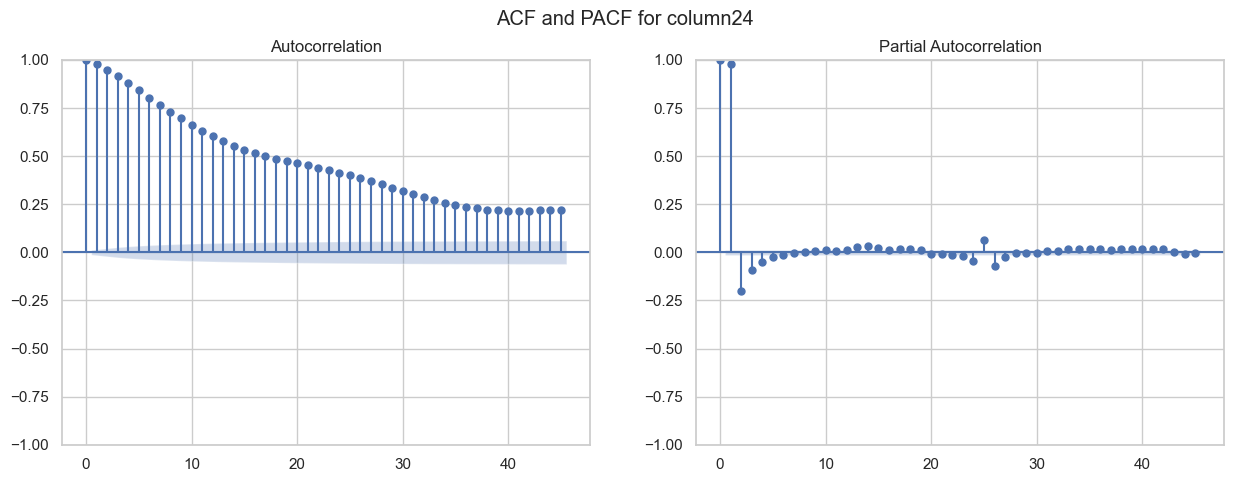

Results of Dickey-Fuller Test for column24:
Test Statistic                -1.554927e+01
p-value                        2.110266e-28
#Lags Used                     4.900000e+01
Number of Observations Used    2.621300e+04
dtype: float64


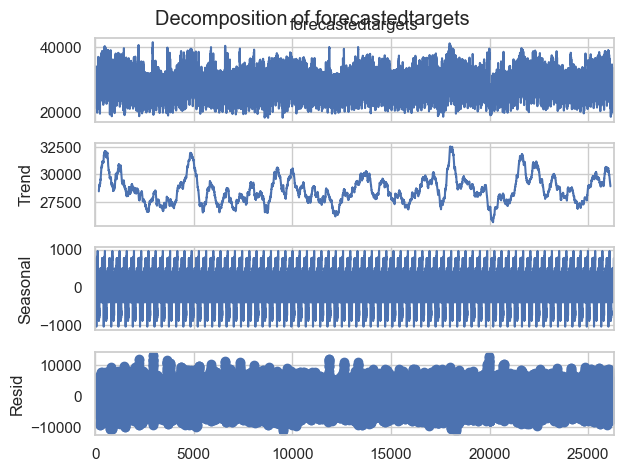

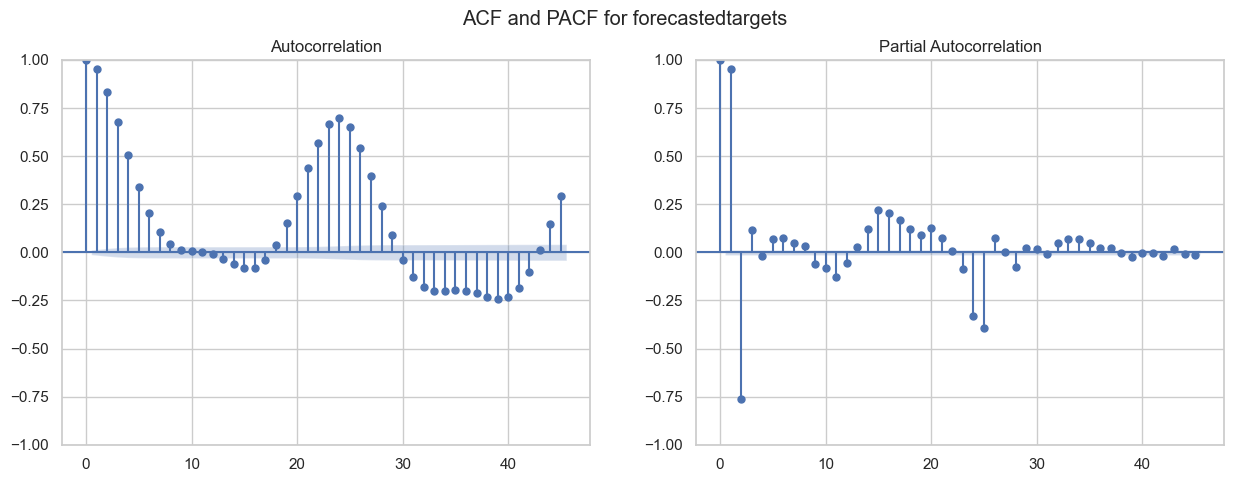

Results of Dickey-Fuller Test for forecastedtargets:
Test Statistic                   -19.476147
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26213.000000
dtype: float64


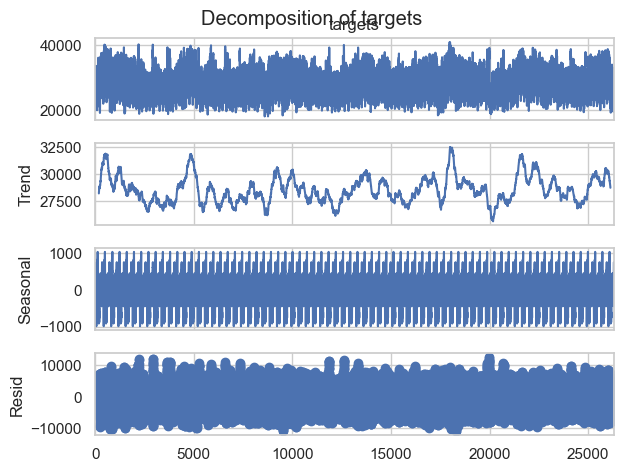

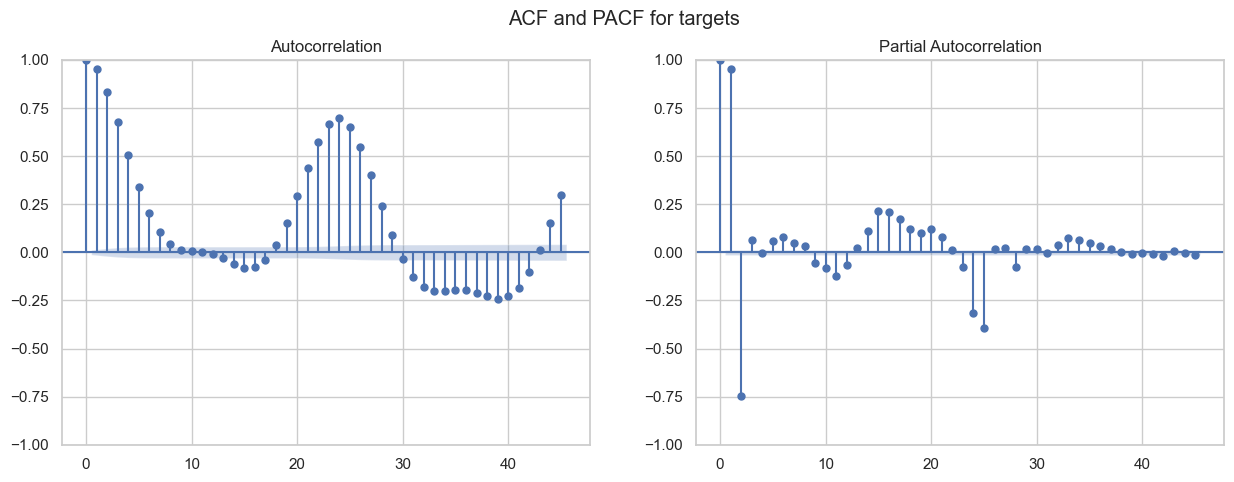

Results of Dickey-Fuller Test for targets:
Test Statistic                   -19.446855
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26213.000000
dtype: float64


In [314]:
# Fonction pour analyser une série temporelle
def analyze_series(df, column_name):
    series = df[column_name]

    # Décomposition de la série temporelle
    decomposition = sm.tsa.seasonal_decompose(series.dropna(), model='additive', period=365)

    # Test de Dickey-Fuller
    dickey_fuller_result = adfuller(series.dropna())
    df_test_results = pd.Series(dickey_fuller_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    return decomposition, df_test_results

# Appliquer l'analyse sur chaque colonne
results = {}
for column in [col for col in train_df.columns if col != 'time']:
    decomposition, df_test_results = analyze_series(train_df, column)
    results[column] = {'Decomposition': decomposition, 'Dickey-Fuller': df_test_results}

    # Afficher les graphiques de décomposition
    decomposition.plot()
    plt.suptitle(f'Decomposition of {column}')
    plt.show()

    # Afficher les graphiques ACF et PACF
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(train_df[column].dropna(), ax=axes[0])
    plot_pacf(train_df[column].dropna(), ax=axes[1])
    plt.suptitle(f'ACF and PACF for {column}')
    plt.show()

    # Afficher les résultats du test de Dickey-Fuller
    print(f'Results of Dickey-Fuller Test for {column}:')
    print(df_test_results)

Chaque série est décomposée en trois composantes principales : tendance, saisonnalité, et résidus, à l’aide de la méthode de décomposition additive. Nous évaluons ensuite la stationnarité des séries avec le test de Dickey-Fuller. Enfin, les graphiques d’autocorrélation (ACF) et d’autocorrélation partielle (PACF) sont générés pour explorer les dépendances temporelles.

## Analyse des targets

Results of Dickey-Fuller Test:
Test Statistic                   -19.446855
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26213.000000
dtype: float64


<Figure size 1200x800 with 0 Axes>

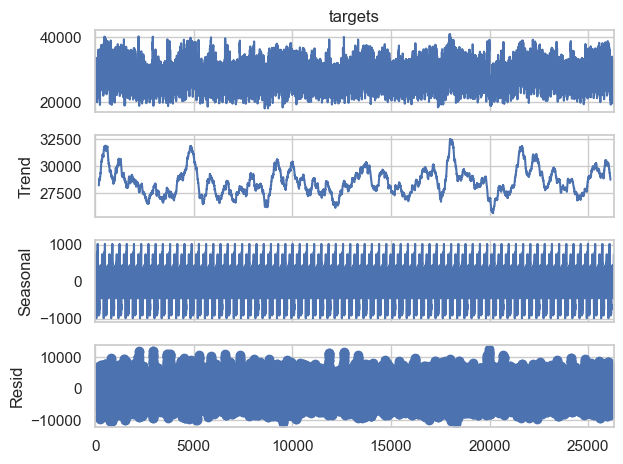

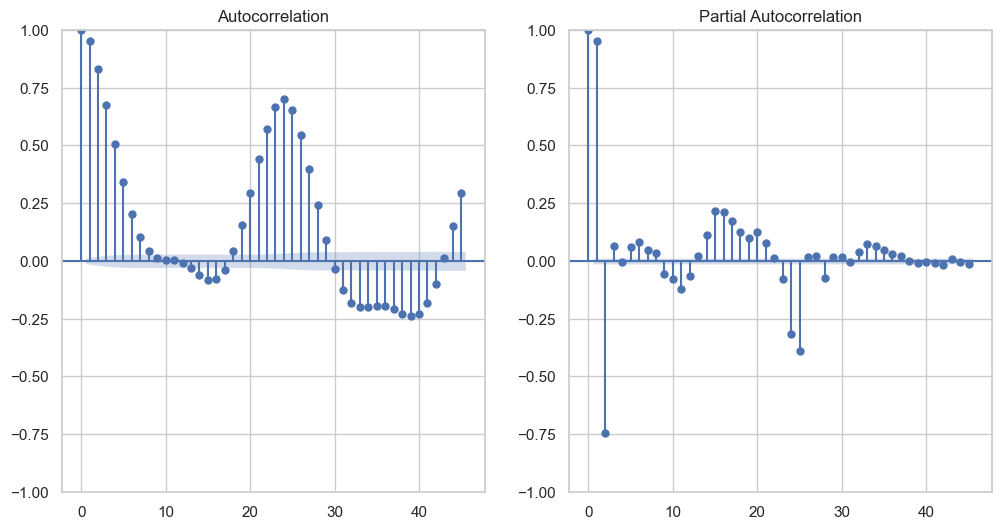

In [315]:
# Sélectionner la série temporelle des cibles d'entraînement
series = train_df['targets']

# Décomposition de la série temporelle
decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=365)

# Test de Dickey-Fuller pour vérifier la stationnarité
dickey_fuller_result = adfuller(series.dropna())
dfoutput = pd.Series(dickey_fuller_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

# Afficher les résultats du test de Dickey-Fuller
print('Results of Dickey-Fuller Test:')
print(dfoutput)

# Tracer la décomposition de la série temporelle
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

# Tracer les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF)
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(series.dropna(), ax=plt.gca())

plt.subplot(122)
plot_pacf(series.dropna(), ax=plt.gca())

plt.show()

Nous pouvons remarquer que nous avons, pour l'ensemble de nos tests, nous avons $p-value \lt  0,05$. Cela signifie que nous pouvons rejeter l'hypothèse que nos séries ne sont pas stationnaires. Ainsi, nous pouvons affirmer que celles-ci $\textbf{sont stationnaires}$.

# Prédictions

## Techniques de lissage

### Moyenne mobile

In [316]:
window_size = 55
#train_df['time'] = pd.to_datetime(train_df['time'], format='%Y-%m-%d %H:%M:%S%z')
#test_df['time'] = pd.to_datetime(test_df['time'], format='%Y-%m-%d %H:%M:%S%z')
# MA
train_df['MA_Targets'] = train_df['targets'].rolling(window=window_size).mean()

# Display the DataFrame with the new MA column
print(train_df[['time','forecastedtargets','targets', 'MA_Targets',]])

cleaned_df = train_df.dropna(subset=['forecastedtargets', 'targets', 'MA_Targets'])

# Calcul du MSE entre les prévisions et les cibles réelles
mse_forecasted = mean_squared_error(cleaned_df['targets'], cleaned_df['forecastedtargets'])
print(f'MSE - Forecasted Targets: {mse_forecasted}')

# Calcul du MSE entre MA et les cibles réelles
mse_ma = mean_squared_error(cleaned_df['targets'].dropna(), cleaned_df['MA_Targets'].dropna())
print(f'MSE - MA Targets: {mse_ma}')

                            time  forecastedtargets  targets    MA_Targets
0      2015-01-01 00:00:00+01:00              26118  25385.0           NaN
1      2015-01-01 01:00:00+01:00              24934  24382.0           NaN
2      2015-01-01 02:00:00+01:00              23515  22734.0           NaN
3      2015-01-01 03:00:00+01:00              22642  21286.0           NaN
4      2015-01-01 04:00:00+01:00              21785  20264.0           NaN
...                          ...                ...      ...           ...
26302  2017-12-31 22:00:00+01:00              25114  25043.0  25736.309091
26303  2017-12-31 23:00:00+01:00              24084  23680.0  25634.218182
26304  2018-01-01 00:00:00+01:00              23324  22779.0  25510.490909
26305  2018-01-01 01:00:00+01:00              22688  22009.0  25342.000000
26306  2018-01-01 02:00:00+01:00              21521  20589.0  25140.345455

[26263 rows x 4 columns]
MSE - Forecasted Targets: 222053.11755503833
MSE - MA Targets: 17800181.72

/var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/ipykernel_7604/1717537781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['MA_Targets'] = train_df['targets'].rolling(window=window_size).mean()


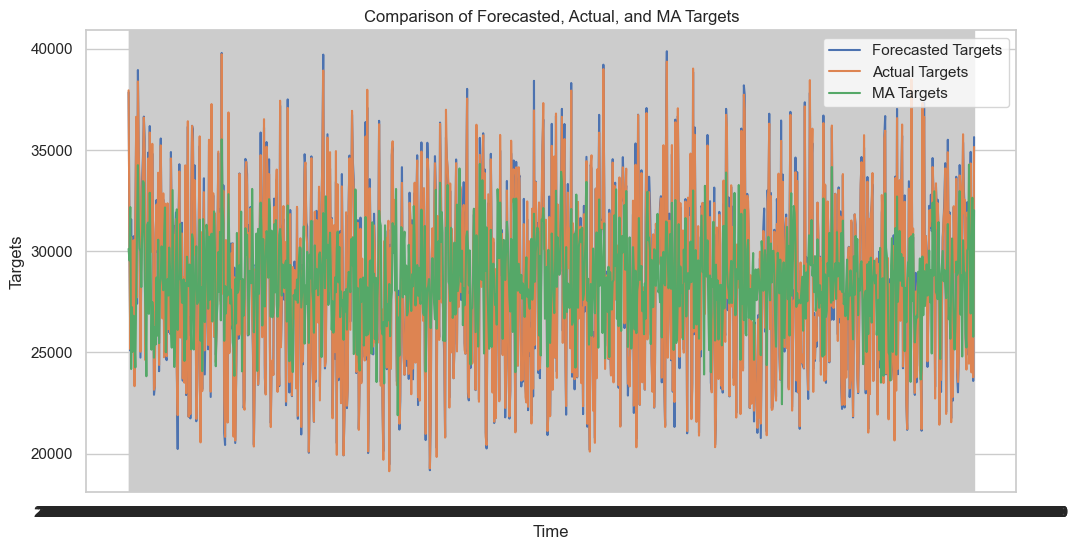

In [317]:
sample_df = cleaned_df.sample(n=1000, random_state=1)

plt.figure(figsize=(12, 6))
plt.plot(sample_df['time'], sample_df['forecastedtargets'], label='Forecasted Targets')
plt.plot(sample_df['time'], sample_df['targets'], label='Actual Targets')
plt.plot(sample_df['time'], sample_df['MA_Targets'], label='MA Targets')
plt.xlabel('Time')
plt.ylabel('Targets')
plt.title('Comparison of Forecasted, Actual, and MA Targets')
plt.legend()
plt.show()

In [318]:
# Calcul du MSE entre les prévisions et les cibles réelles
mse_forecasted = mean_squared_error(cleaned_df['targets'], cleaned_df['forecastedtargets'])
print(f'MSE - Forecasted Targets: {mse_forecasted}')

# Calcul du MSE entre MA et les cibles réelles
mse_ma = mean_squared_error(cleaned_df['targets'].dropna(), cleaned_df['MA_Targets'].dropna())
print(f'MSE - MA Targets: {mse_ma}')

MSE - Forecasted Targets: 222053.11755503833
MSE - MA Targets: 17800181.723262854


In [319]:
last_ma_value = train_df['MA_Targets'].iloc[-1] # Get the last MA value from the training data
test_df['MA_Predictions'] = [last_ma_value] * len(test_df) # Set the MA prediction for the test data

/var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/ipykernel_7604/2054065988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Predictions'] = [last_ma_value] * len(test_df) # Set the MA prediction for the test data


### Lissage exponentiel

In [320]:
# Initialisation de la liste pour stocker les résultats
results = []

# Tester les valeurs de smoothing_level de 0 à 1 par gap de 0.1
for smoothing_level in np.arange(0, 1.1, 0.1):
    # Entraînement du modèle avec le smoothing_level actuel
    model = SimpleExpSmoothing(train_df['targets'])
    model_fit = model.fit(smoothing_level=smoothing_level)

    # Prédictions sur l'ensemble de test
    test_df['ES_Predictions'] = model_fit.forecast(len(test_df))

    # Calcul du MSE pour ce smoothing_level
    mse = mean_squared_error(test_df.dropna()['targets'], test_df.dropna()['ES_Predictions'])

    # Stockage des résultats
    results.append((smoothing_level, mse))

# Tri des résultats par MSE
sorted_results = sorted(results, key=lambda x: x[1])

print(sorted_results)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(

[(0.0, 35073165.24342634), (0.1, 41701780.882012464), (0.2, 48707837.746446334), (0.30000000000000004, 58340957.166174084), (0.4, 67458955.71090591), (0.5, 74813935.57820952), (0.6000000000000001, 80426456.07871757), (0.7000000000000001, 84720393.30093297), (0.8, 88140640.20614336), (0.9, 91017939.98835014), (1.0, 93556673.01056379)]


/var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/ipykernel_7604/2287655390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ES_Predictions'] = model_fit.forecast(len(test_df))


In [321]:
# Suppression des lignes où les valeurs de 'targets', 'MA_Predictions', 'ES_Predictions', ou 'forecastedtargets' sont NaN
test_df_cleaned = test_df.dropna(subset=['targets', 'MA_Predictions', 'ES_Predictions', 'forecastedtargets'])

# Recalcul du MSE pour la moyenne mobile
mse_ma = mean_squared_error(test_df_cleaned['targets'], test_df_cleaned['MA_Predictions'])
print(f'Mean Squared Error (MSE) - Moving Average: {mse_ma:.2f}')

# Recalcul du MSE pour le lissage exponentiel
mse_es = mean_squared_error(test_df_cleaned['targets'], test_df_cleaned['ES_Predictions'])
print(f'Mean Squared Error (MSE) - Exponential Smoothing: {mse_es:.2f}')

# Recalcul du MSE pour les prévisions industrielles
mse_forecasted = mean_squared_error(test_df_cleaned['targets'], test_df_cleaned['forecastedtargets'])
print(f'Mean Squared Error (MSE) - Forecasted Targets: {mse_forecasted:.2f}')

Mean Squared Error (MSE) - Moving Average: 36943030.70
Mean Squared Error (MSE) - Exponential Smoothing: 93556673.01
Mean Squared Error (MSE) - Forecasted Targets: 152006.56


### Conclusions

Le meilleur coefficient de smoothing_level est 0.4 et le meilleur window_size est de 55.

Cependant, les résultats restent beaucoup moins bons que le prédictions faites par les ingénieurs. Ces modèles sont trop simplises pour capturer l'ensemble de la variance de nos données et ne permettent ainsi pas d'obtenir de bons résultats.


## Modèles autoregressifs

### AR

In [322]:
# Fonction de lookback
def create_lookback_dataset(dataset, look_back=1):
    """
    Crée des ensembles de données X et Y pour des séries temporelles avec un lookback donné.

    :param dataset: Liste ou tableau des données d'entrée.
    :param look_back: Nombre de pas en arrière à considérer pour les prédictions (par défaut : 1).
    :return: dataX, dataY - deux tableaux numpy pour les caractéristiques et les cibles.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [323]:
# Application de la fonction pour créer les ensembles d'entraînement et de test
look_back = 10
trainX, trainY = create_lookback_dataset(train_df ['targets'].values, look_back)
testX, testY = create_lookback_dataset(test_df['targets'].values, look_back)

In [324]:
# Entraînement du modèle 
model_ar = AutoReg(trainY, lags=look_back)
model_ar_fit = model_ar.fit()

# Prédiction sur l'ensemble de test
predictions_ar = model_ar_fit.predict(start=len(trainY), end=len(trainY) + len(testY) - 1, dynamic=False)

### ARIMA

In [325]:
# Trouver le meilleur modèle ARIMA
model_arima = auto_arima(trainY, start_p=1, start_q=1,
                         max_p=5, max_q=5, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(model_arima.summary())

/opt/homebrew/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=437323.219, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=455960.508, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=438171.280, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=442231.169, Time=3.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=455958.508, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=433885.933, Time=9.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=437079.548, Time=1.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=433830.476, Time=21.74 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=436769.731, Time=2.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=433822.841, Time=32.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=436131.281, Time=3.97 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=44.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=49.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=433815.773, Time=23.38 sec
 ARIMA(2,1,2)(

Le modèle ARIMA(3,1,2) sans interception est optimal dans cette configuration, avec un AIC minimal de 433812.217. Un AIC plus faible indique un meilleur équilibre entre complexité et ajustement des données. Ainsi, ce modèle est considéré comme le plus performant parmi ceux que nous avons testé.

Entrainons maintenant spécifiquement ce modèle.

In [326]:
# Entraînement du modèle ARIMA avec les paramètres choisis
model_arima = ARIMA(trainY, order=(3, 1, 2))
model_arima_fit = model_arima.fit()

# Prédiction sur l'ensemble de test
predictions_arima = model_arima_fit.predict(start=len(trainY), end=len(trainY) + len(testY) - 1, typ='levels')

print(predictions_arima)

# Afficher les statistiques les plus importantes
important_stats = model_arima_fit.summary().tables[1]
print("Les statistiques les plus importantes des prédictions ARIMA :")
print(important_stats)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


[20051.79909453 20300.9655586  21066.07583863 ... 26394.2438182
 26394.2438182  26394.2438182 ]
Les statistiques les plus importantes des prédictions ARIMA :
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2735      0.095     13.440      0.000       1.088       1.459
ar.L2         -0.1450      0.158     -0.917      0.359      -0.455       0.165
ar.L3         -0.2605      0.073     -3.581      0.000      -0.403      -0.118
ma.L1         -0.5706      0.094     -6.074      0.000      -0.755      -0.386
ma.L2         -0.4102      0.093     -4.429      0.000      -0.592      -0.229
sigma2      8.763e+05   3115.344    281.292      0.000     8.7e+05    8.82e+05


In [327]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Appliquer le test de stationnarité
check_stationarity(train_df['targets'])

ADF Statistic: -19.446855
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Conclusions

In [328]:
assert len(predictions_ar) == len(testY)
assert len(predictions_arima) == len(testY)

# Calcul du MSE pour le modèle AR
mse_ar = mean_squared_error(testY, predictions_ar)
print(f'MSE pour le modèle AR: {mse_ar}')

# Calcul du MSE pour le modèle ARIMA
mse_arima = mean_squared_error(testY, predictions_arima)
print(f'MSE pour le modèle ARIMA: {mse_arima}')

# Recalcul du MSE pour les prévisions industrielles
mse_forecasted = mean_squared_error(test_df_cleaned['targets'], test_df_cleaned['forecastedtargets'])
print(f'MSE - Forecasted Targets: {mse_forecasted}')

MSE pour le modèle AR: 21557829.264176663
MSE pour le modèle ARIMA: 28522177.338487152
MSE - Forecasted Targets: 152006.55942128832


## RNN

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 75)             30300     
                                                                 
 dropout_14 (Dropout)        (None, 1, 75)             0         
                                                                 
 lstm_15 (LSTM)              (None, 75)                45300     
                                                                 
 dropout_15 (Dropout)        (None, 75)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 76        
                                                                 
Total params: 75676 (295.61 KB)
Trainable params: 75676 (295.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
26238

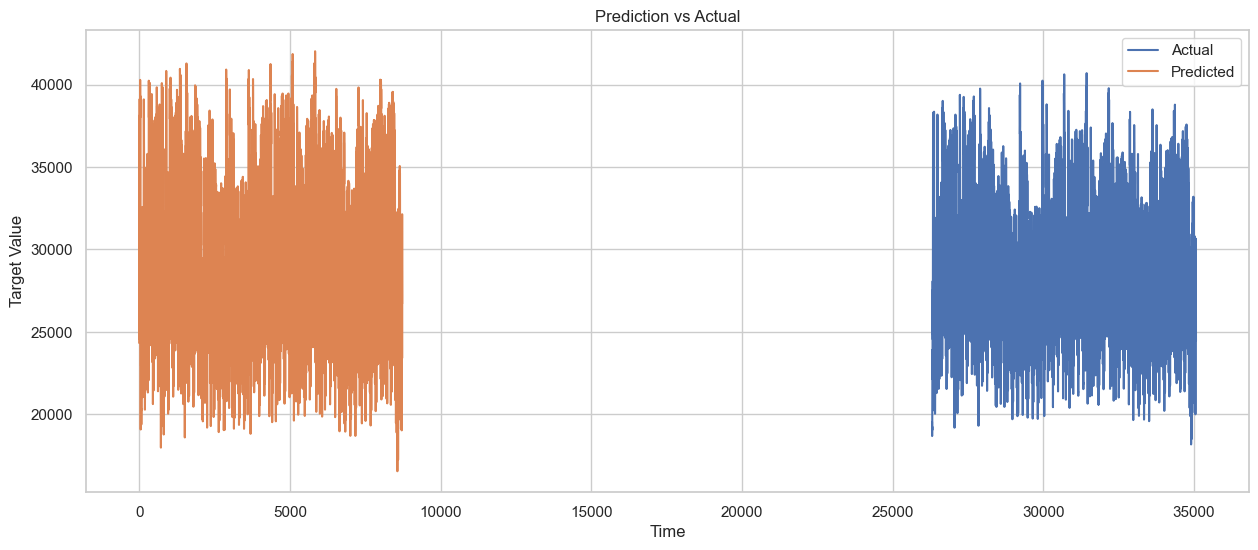

In [330]:
# Initialisation du MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalisation des données d'entraînement et de test
scaled_train = scaler.fit_transform(train_df['targets'].values.reshape(-1, 1))
scaled_test = scaler.transform(test_df['targets'].values.reshape(-1, 1))

look_back = 25  # Peut être ajusté
X_train, Y_train = create_lookback_dataset(scaled_train, look_back)
X_test, Y_test = create_lookback_dataset(scaled_test, look_back)

# Remodeler l'entrée pour être [échantillons, temps, caractéristiques]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Hyperparamètres
num_neurons = 75  # Nombre de neurones dans chaque couche LSTM

# Construction du modèle
model = Sequential()

# Première couche LSTM avec Dropout
model.add(LSTM(num_neurons, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))  # Dropout pour éviter le surajustement

# Deuxième couche LSTM
model.add(LSTM(num_neurons, return_sequences=False))
model.add(Dropout(0.1))  # Dropout pour éviter le surajustement

# Couche de sortie Dense
model.add(Dense(1))  # Une sortie pour les prédictions


# Compilation du modèle
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

# Entraînement du modèle
model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=2)

# Faire des prédictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverser les prédictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


Y_train = np.nan_to_num(Y_train)
train_predict = np.nan_to_num(train_predict)
Y_test = np.nan_to_num(Y_test)
test_predict = np.nan_to_num(test_predict)

# Calcul de l'erreur quadratique moyenne
train_score = math.sqrt(mean_squared_error(Y_train, train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = math.sqrt(mean_squared_error(Y_test, test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

# Tracé des résultats
plt.figure(figsize=(15,6))
plt.plot(test_df['targets'], label='Actual')  # Make sure to use the correct variable for actual values
plt.plot(test_predict[:,0], label='Predicted')
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.legend()
plt.show()

/var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/ipykernel_7604/2000177288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['LSTM_targets'] = np.nan
/var/folders/tk/vtf0wyz161v9t3l4zbzyct5c0000gn/T/ipykernel_7604/2000177288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['LSTM_targets'].iloc[look_back:] = test_predict[:, 0]


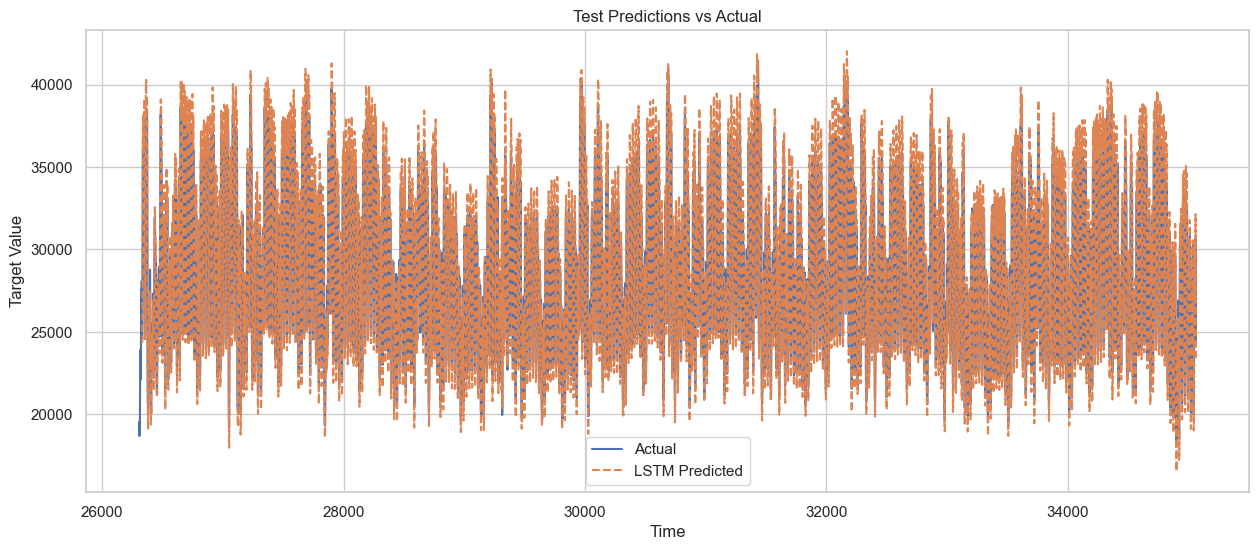

In [331]:
test_predict.shape
# Ajouter des NaN pour les premiers 'look_back' points de temps
test_df['LSTM_targets'] = np.nan

# Assigner les prédictions à la colonne en décalant de 'look_back' indices
test_df['LSTM_targets'].iloc[look_back:] = test_predict[:, 0]

# Tracer la colonne 'targets' et les prédictions 'LSTM_targets'
plt.figure(figsize=(15, 6))
plt.plot(test_df['targets'], label='Actual')
plt.plot(test_df['LSTM_targets'], label='LSTM Predicted', linestyle='--')
plt.title('Test Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.legend()
plt.show()

## Conclusions et résultats finaux

| **Modèle**              | **MSE**                   |
|------------------------|---------------------------|
| **Moyenne glissante - Mooving Average (MA)** | 36943030.70          |
| **Lissage exponentiel (ES)**       | 93556673.01          |
| **Autorégression (AR)**       | 21557829.26          |
| **Modèle ARIMA**       | 28522177.34          |
| **Réseau de neuronnes récurent (RNN - LSTM)** | 29316.80       |
| **Forecasted Target**         | 152006.56            |

## Observations

- Le modèle **Réseau de Neurones Récurrent (RNN - LSTM)** présente le **MSE le plus bas** (**129316.80**), ce qui en fait le modèle offrant la meilleure précision de prédiction sur ce dataset. Cela met en lumière l'efficacité des approches neuronales avancées pour capturer les schémas complexes des séries temporelles.
- Le modèle **Forecasted Target**, avec un MSE de **152006.56**, se classe en deuxième position. Bien que légèrement moins performant que le RNN, il reste très compétitif et pourrait être une alternative intéressante dans certains cas.
- Le modèle **Autorégression (AR)** se démarque parmi les méthodes traditionnelles, avec un MSE de **21557829.26**, surpassant à la fois la **Moyenne Glissante (MA)** et le **Lissage Exponentiel (ES)**.
- La **Moyenne Glissante (MA)** affiche un MSE de **36943030.70**, ce qui reflète des performances correctes, mais inférieures à celles des modèles plus sophistiqués.
- Le **Lissage Exponentiel (ES)**, avec un MSE de **93556673.01**, est le modèle le moins performant sur ce dataset, ce qui peut s'expliquer par son incapacité à gérer les variations complexes des données.

## Conclusion

Le modèle **RNN - LSTM** est le plus performant avec le plus faible MSE, démontrant sa capacité à capturer efficacement les dépendances temporelles complexes. Bien que le modèle **Forecasted Target** soit proche en termes de précision, le RNN reste l'option la plus fiable pour ce dataset. Parmi les modèles traditionnels, l'**AR** et l'**ARIMA** se distinguent par des performances acceptables, tandis que les approches simples comme la **Moyenne Glissante (MA)** et le **Lissage Exponentiel (ES)** montrent des limites claires pour ce type de données. Ces résultats mettent en évidence l'importance des approches neuronales dans le domaine des séries temporelles.


# Reinforcement learning

In [350]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.001
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 10
MAX_EPISODES = 1000
BUFFER_SIZE = 10000
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01

In [351]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [352]:
# Initialize environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize networks
q_network = QNetwork(state_dim, action_dim)
target_network = QNetwork(state_dim, action_dim)
target_network.load_state_dict(q_network.state_dict())  # Initialize with same weights
target_network.eval()

# Optimizer and replay buffer
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
replay_buffer = deque(maxlen=BUFFER_SIZE)

# Epsilon-greedy policy
epsilon = 1.0

In [353]:
def update_q_network():
    if len(replay_buffer) < BATCH_SIZE:
        return  # Skip if not enough samples in the buffer

    # Sample a batch from the buffer
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convert to tensors
    states = torch.stack(states)
    actions = torch.tensor(actions).unsqueeze(1)
    rewards = torch.tensor(rewards).unsqueeze(1)
    next_states = torch.stack(next_states)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)  # Convert to float32

    # Compute targets
    with torch.no_grad():
        target_q_values = target_network(next_states).max(1, keepdim=True)[0]
        targets = rewards + (1.0 - dones) * GAMMA * target_q_values

    # Compute current Q-values
    q_values = q_network(states).gather(1, actions)

    # Compute loss
    loss = nn.functional.mse_loss(q_values, targets)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [354]:
for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    total_reward = 0

    for t in range(500):
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(q_network(state)).item()

        # Take action
        next_state, reward, done, truncated, _ = env.step(action)
        terminal = done or truncated
        next_state = torch.tensor(next_state, dtype=torch.float32)

        # Store transition in buffer
        replay_buffer.append((state, action, reward, next_state, terminal))

        # Update state and total reward
        state = next_state
        total_reward += reward

        # Update Q-network
        update_q_network()

        # End episode if terminal
        if terminal:
            break

    # Update target network periodically
    if episode % TARGET_UPDATE_FREQ == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Decay epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")

Episode 0, Total Reward: 10.0, Epsilon: 0.995
Episode 1, Total Reward: 60.0, Epsilon: 0.990025
Episode 2, Total Reward: 15.0, Epsilon: 0.985074875
Episode 3, Total Reward: 23.0, Epsilon: 0.9801495006250001
Episode 4, Total Reward: 9.0, Epsilon: 0.9752487531218751
Episode 5, Total Reward: 14.0, Epsilon: 0.9703725093562657
Episode 6, Total Reward: 18.0, Epsilon: 0.9655206468094844
Episode 7, Total Reward: 29.0, Epsilon: 0.960693043575437
Episode 8, Total Reward: 17.0, Epsilon: 0.9558895783575597
Episode 9, Total Reward: 15.0, Epsilon: 0.9511101304657719
Episode 10, Total Reward: 27.0, Epsilon: 0.946354579813443
Episode 11, Total Reward: 14.0, Epsilon: 0.9416228069143757
Episode 12, Total Reward: 15.0, Epsilon: 0.9369146928798039
Episode 13, Total Reward: 20.0, Epsilon: 0.9322301194154049
Episode 14, Total Reward: 33.0, Epsilon: 0.9275689688183278
Episode 15, Total Reward: 12.0, Epsilon: 0.9229311239742362
Episode 16, Total Reward: 20.0, Epsilon: 0.918316468354365
Episode 17, Total Reward

Nous pouvons voir qu'avec un learning rate de 0,001, nous atteignons un reward de 500 en moins de 1000 étapes.

In [355]:
state, _ = env.reset()  # Compatible avec les versions récentes de Gym
state = torch.tensor(state, dtype=torch.float32)
done = False

while not done:
    # Choisir l'action en fonction du Q-network
    action = torch.argmax(q_network(state)).item()
    next_state, reward, done, truncated, _ = env.step(action)
    state = torch.tensor(next_state, dtype=torch.float32)
    env.render()